<a href="https://colab.research.google.com/github/leowu4ever/PhD_Note/blob/master/ancon_sample_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data exploration**

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


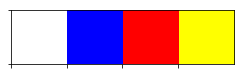

In [0]:
#@title Housekeeping { vertical-output: true, form-width: "30%" }
import pandas as pd
import numpy as np
from scipy import stats
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from google.colab import drive
drive.mount('/content/gdrive')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

folder_path = '/content/gdrive/My Drive/ancon_sample_dataset/'
file_names = {
    'BACKGROUND'            : '180411_042123_3.csv',
    'NORMAL_LUNG_CELLS'     : '180411_055221_3.csv',
    'LUNG_CANCER'           : '180411_071824_3.csv',
    'LEUKAEMIA'             : '180411_091900_3.csv',
    'EXAMPLE_BREATH_SAMPLE' : '180301_162330_3.csv'
}

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
color_space = ["white", "blue", "red", "yellow"]
color_palette = sns.color_palette(color_space).as_hex()
my_cmap = LinearSegmentedColormap.from_list('my_cmap', color_palette)
sns.palplot(sns.color_palette(color_space).as_hex())

In [0]:
#@title Dataset format description { vertical-output: true, form-width: "30%" }
Image('/content/gdrive/My Drive/ancon_sample_dataset/dataset_labels.png')
print ('drift times - Yellow')
print ('spectrum number - red')
print ('retention times - orange')
print ('intensity data - green')

for name in file_names:
  shape = pd.read_csv(folder_path + file_names[name], sep=';', index_col='#SpecNum').shape
  print(name + ' file\'s shape is' + str(shape))

In [0]:
#@title Show a dateset { vertical-output: true, form-width: "30%" }
file_selected = "BACKGROUND" #@param ["BACKGROUND", "NORMAL_LUNG_CELLS", "LUNG_CANCER", "LEUKAEMIA", "EXAMPLE_BREATH_SAMPLE"]
row_displayed = 1 #@param {type:"integer"}

df = pd.read_csv(folder_path + file_names[file_selected], sep=';', index_col='RetTime [s] \\ DriftTime [ms]')
df.head(row_displayed)

# **Pre-processing**

df2439348.8270000033


(954, 1754)

(800, 0.0)

subset_based drift time alignment2439348.8270000033


Text(0.5, 69.0, 'Drift time[ms]')

Text(69.0, 0.5, 'Retention time[s]')

Text(0.5, 1.0, 'BACKGROUND')

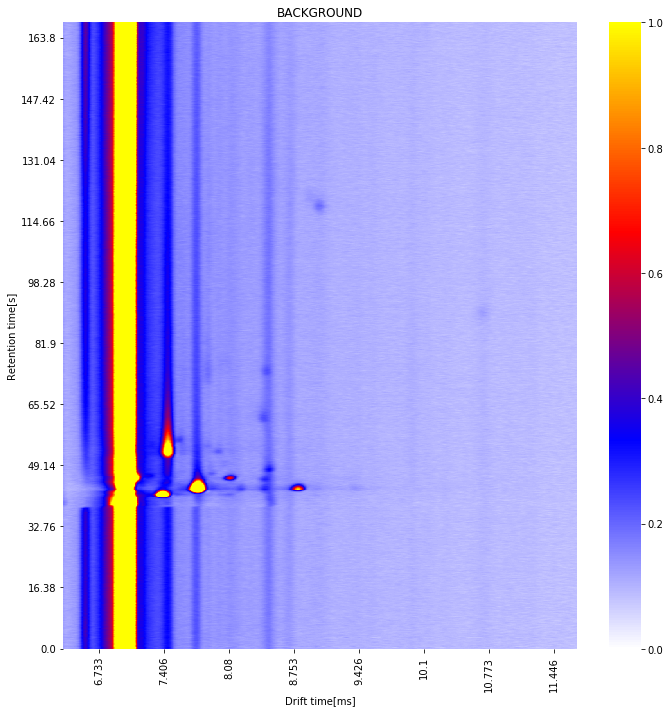

In [0]:
#@title { form-width: "30%" }
file_selected = "BACKGROUND" #@param ["BACKGROUND", "NORMAL_LUNG_CELLS", "LUNG_CANCER", "LEUKAEMIA", "EXAMPLE_BREATH_SAMPLE"]
width = 10 #@param {type:"integer"}
height = 10 #@param {type:"integer"}
intensity_min_displayed = 0 #@param {type:"number"}
intensity_max_displayed = 1 #@param {type:"number"}

quantile_threshold = 0.25 #@param {type:"number"}
RIP_detailing_method = "off" #@param ["off", "quantiles_based"]
normalisation_method = "off" #@param ["off", "subset_based"]
denoising_method = "off" #@param ["off", "median_filter"]
smoothing_method = "off" #@param ["off", "gaussian_filter"]
drift_time_alignment_method = "subset_based" #@param ["off", "subset_based"]

df = pd.read_csv(folder_path + file_names[file_selected], sep=';', index_col='RetTime [s] \\ DriftTime [ms]')
df = df.drop(columns=['#SpecNum'])
print("df" + str(df.sum().sum()))

if (RIP_detailing_method == 'quantiles_based'):
  low_quantile_df = df.quantile(quantile_threshold)
  df = df - low_quantile_df
  print("quantiles_based RIP" + str(df.sum().sum()))

df_drift_time_subset = df.iloc[-100:,:]
if (normalisation_method == 'subset_based'):
  df_intensity_max = df_drift_time_subset.max().max()
  df = df / df_intensity_max
  print("subset_based normalisation" + str(df.sum().sum()))

if (denoising_method == 'median_filter'):
  intensity_matrix = df.to_numpy()
  intensity_matrix_median_filtered = medfilt2d(intensity_matrix, kernel_size=5)
  df_median_filtered = pd.DataFrame(intensity_matrix_median_filtered)
  df_median_filtered.columns = df.columns
  df_median_filtered.index = df.index
  df = df_median_filtered
  print("median_filter denoising" + str(df.sum().sum()))

if (smoothing_method == 'gaussian_filter'):
  intensity_matrix = df.to_numpy()
  intensity_matrix_gaussian_filtered = gaussian_filter(intensity_matrix, sigma=np.std(intensity_matrix))
  df_gaussian_filtered = pd.DataFrame(intensity_matrix_gaussian_filtered)
  df_gaussian_filtered.columns = df.columns
  df_gaussian_filtered.index = df.index
  df = df_gaussian_filtered
  print("gaussian_filter smoothing" + str(df.sum().sum()))

fig = plt.figure(figsize=(width,height))
ax = sns.heatmap(df, vmin=intensity_min_displayed, vmax=intensity_max_displayed, cmap=my_cmap)

if (drift_time_alignment_method == 'subset_based'):
  drift_time_alignment_point = df_drift_time_subset.idxmax(axis=1).median()
  drift_time_alignment_index_start = df_drift_time_subset.columns.get_loc(str(drift_time_alignment_point))
  plt.gca().set_xlim(left=drift_time_alignment_index_start-100, right=drift_time_alignment_index_start+700)
  plt.gca().set_ylim(bottom=800)
  print("subset_based drift time alignment" + str(df.sum().sum()))

ax.invert_yaxis()
plt.xlabel('Drift time[ms]')
plt.ylabel('Retention time[s]')
plt.title(file_selected)
plt.tight_layout()
plt.show()
fig.savefig(folder_path + file_selected + '.jpg')

# **Peak picking**